In [4]:
# Install Poppler
!apt-get update -qq
!apt-get install -y poppler-utils


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 152 not upgraded.


In [5]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
from pdf2image import convert_from_path
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


print(torch.__version__)

2.5.1+cu124


In [6]:
processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): TableTransformerFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): TableTransformerFrozenBatchNorm2d()
              (drop_block): Identity()
              (act1): ReLU(inplace=True)
              (aa): Identity()
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): TableTransformerFrozenBatchNorm2d()
              (act2): ReLU(inplac

In [7]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 152 not upgraded.


Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



── Processing Page 1/11 ──


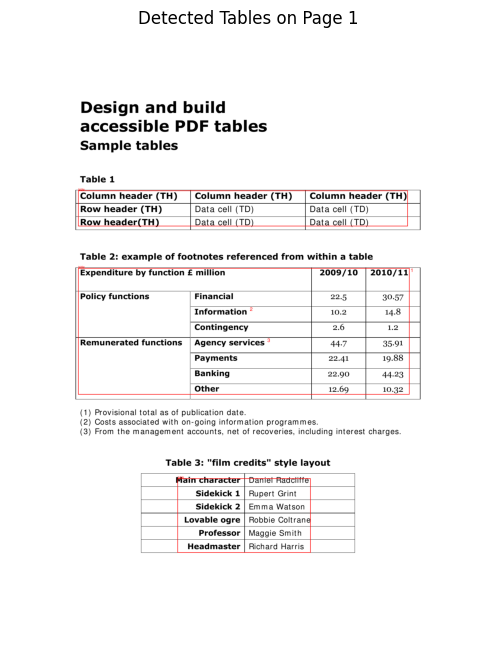


── Processing Page 2/11 ──


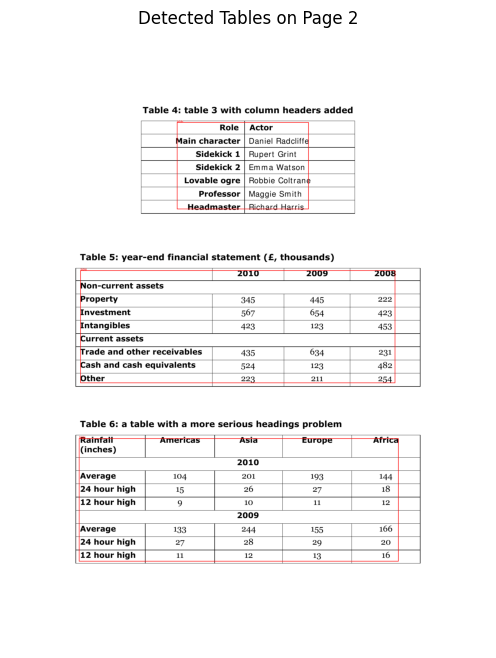


── Processing Page 3/11 ──


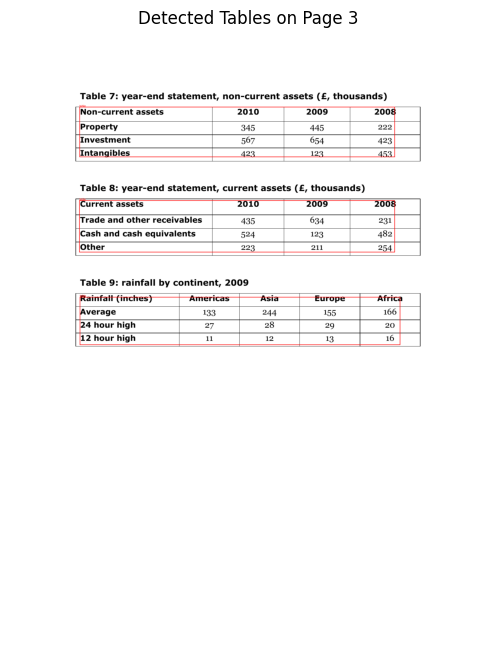


── Processing Page 4/11 ──


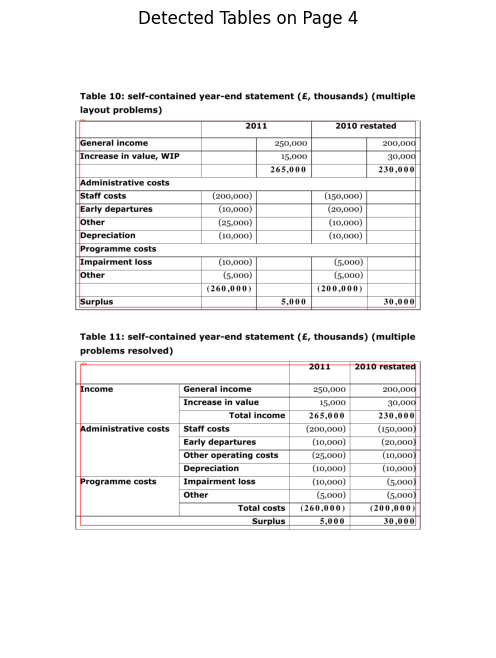


── Processing Page 5/11 ──


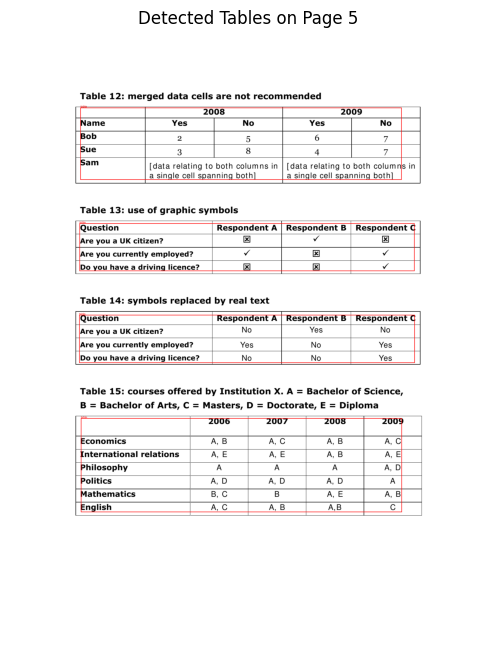


── Processing Page 6/11 ──


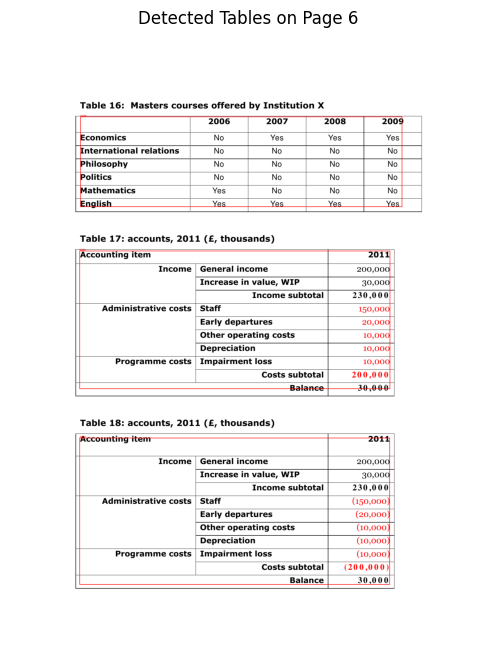


── Processing Page 7/11 ──


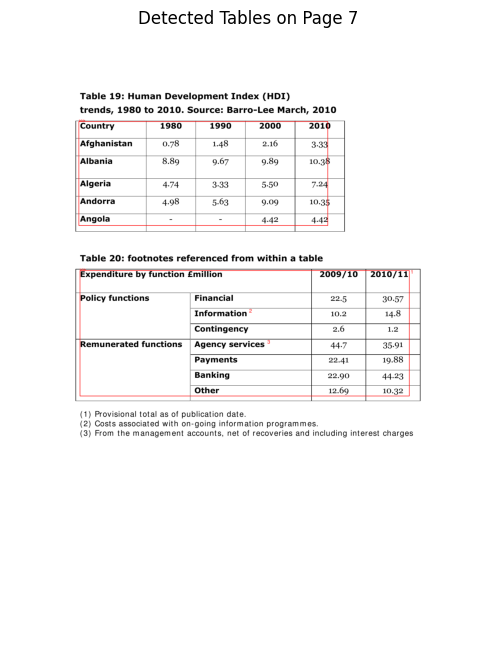


── Processing Page 8/11 ──


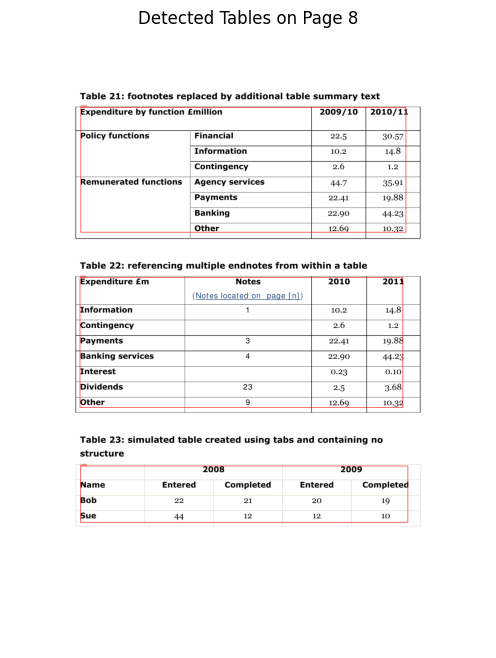


── Processing Page 9/11 ──


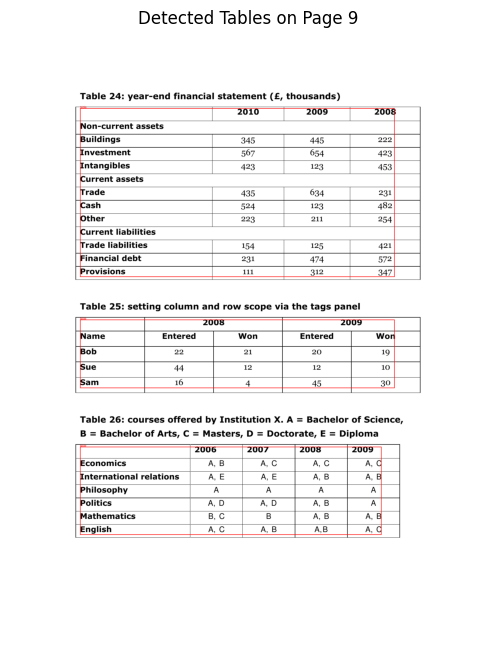


── Processing Page 10/11 ──


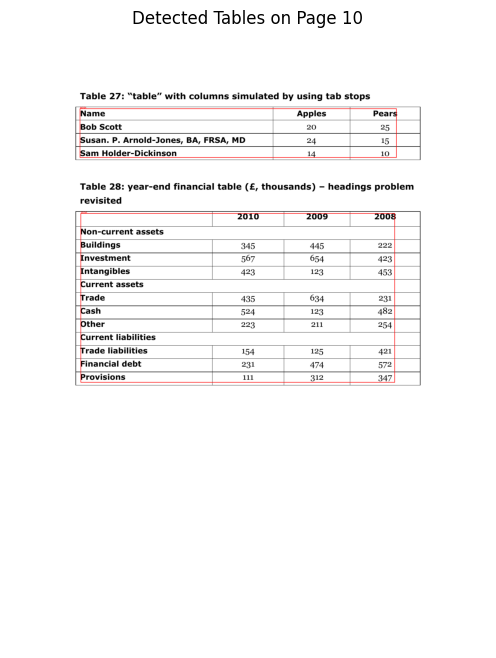


── Processing Page 11/11 ──


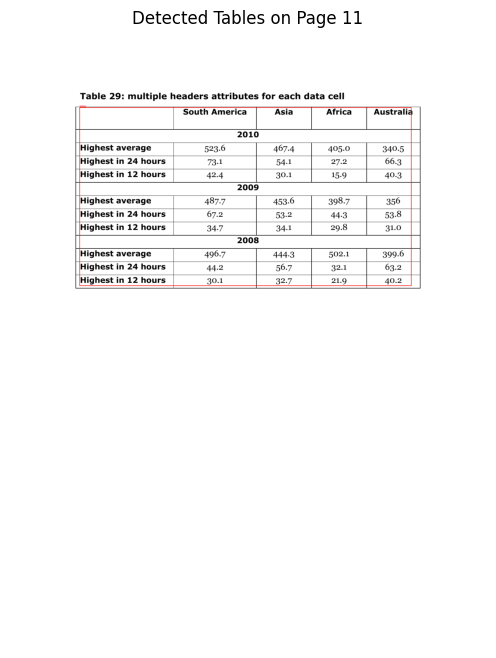

In [8]:
import os
import json
import torch
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image, ImageDraw
from IPython.display import display, HTML
from transformers import AutoImageProcessor, AutoModelForObjectDetection

# ── Configuration ──────────────────────────────────────────────────────────────
PDF_PATH      = "/kaggle/input/tables/sample-tables.pdf"
OUTPUT_DIR    = "./outputs"
CONF_THRES    = 0.7   # detection confidence threshold
DPI           = 200   # resolution for PDF→image

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── 1. Load Table Transformer ──────────────────────────────────────────────────
processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model     = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection")
device    = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# ── 2. PDF → Images ─────────────────────────────────────────────────────────────
def pdf_to_images(pdf_path, dpi=DPI):
    try:
        return convert_from_path(pdf_path, dpi=dpi)
    except Exception as e:
        raise RuntimeError(f"Failed to convert PDF → images: {e}")

# ── 3. Detect Tables ────────────────────────────────────────────────────────────
def detect_tables(img):
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    target_sizes = torch.tensor([img.size[::-1]]).to(device)
    results = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=CONF_THRES
    )[0]
    return results

# ── 4. Generate HTML ───────────────────────────────────────────────────────────
# def tables_to_html(results):
#     html = "<table border='1' style='border-collapse:collapse;'>"
#     html += "<tr><th>Index</th><th>Label</th><th>Score</th><th>Box [x1,y1,x2,y2]</th></tr>"
#     for idx, (label, score, box) in enumerate(zip(results["labels"], results["scores"], results["boxes"])):
#         html += (
#             f"<tr>"
#             f"<td>{idx}</td>"
#             f"<td>{model.config.id2label[label.item()]}</td>"
#             f"<td>{score:.3f}</td>"
#             f"<td>{[round(x,2) for x in box.tolist()]}</td>"
#             f"</tr>"
#         )
#     html += "</table>"
#     return html

# ── 5. Draw & Display ───────────────────────────────────────────────────────────
def draw_boxes(img, results):
    img_boxed = img.copy()
    draw = ImageDraw.Draw(img_boxed)
    for label, box in zip(results["labels"], results["boxes"]):
        box = [round(x,2) for x in box.tolist()]
        draw.rectangle(box, outline="red", width=2)
        draw.text((box[0], box[1]-10), model.config.id2label[label.item()], fill="red")
    return img_boxed

# ── 6. Save JSON ────────────────────────────────────────────────────────────────
# def save_json(page_idx, results):
#     data = []
#     for label, score, box in zip(results["labels"], results["scores"], results["boxes"]):
#         data.append({
#             "label": model.config.id2label[label.item()],
#             "score": float(score),
#             "box": [round(x,2) for x in box.tolist()]
#         })
#     out_path = os.path.join(OUTPUT_DIR, f"page_{page_idx+1}_tables.json")
#     with open(out_path, "w") as f:
#         json.dump(data, f, indent=2)
#     return out_path

# ── 7. Full Pipeline ────────────────────────────────────────────────────────────
images = pdf_to_images(PDF_PATH, dpi=DPI)

for i, page_img in enumerate(images):
    print(f"\n── Processing Page {i+1}/{len(images)} ──")
    
    # 1. Detect
    results = detect_tables(page_img.convert("RGB"))
    
    # # 2. Generate & display HTML
    # html = tables_to_html(results)
    # display(HTML(html))
    
    # 3. Draw boxes & show
    boxed_img = draw_boxes(page_img.convert("RGB"), results)
    plt.figure(figsize=(8,8))
    plt.imshow(boxed_img)
    plt.axis("off")
    plt.title(f"Detected Tables on Page {i+1}")
    plt.show()
    
    # # 4. Save JSON
    # json_path = save_json(i, results)
    # print(f"Saved JSON: {json_path}")

Total tables found: 29


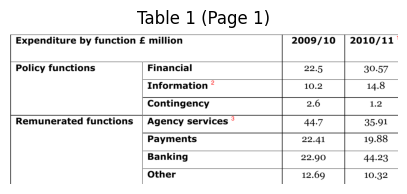

Saved cropped table to: /kaggle/working/croped/table_1_page1.png


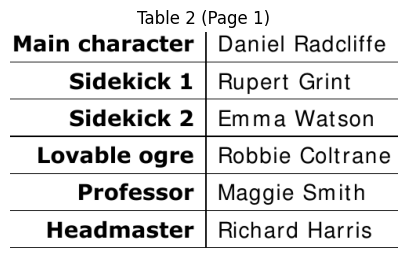

Saved cropped table to: /kaggle/working/croped/table_2_page1.png


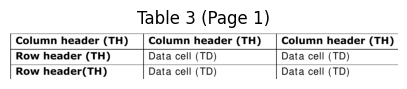

Saved cropped table to: /kaggle/working/croped/table_3_page1.png


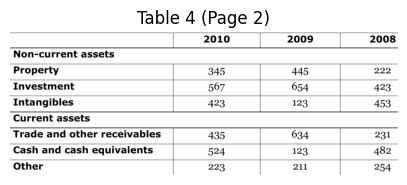

Saved cropped table to: /kaggle/working/croped/table_4_page2.png


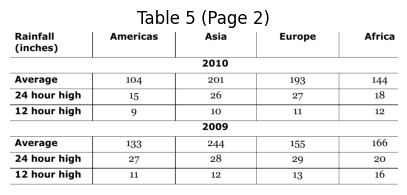

Saved cropped table to: /kaggle/working/croped/table_5_page2.png


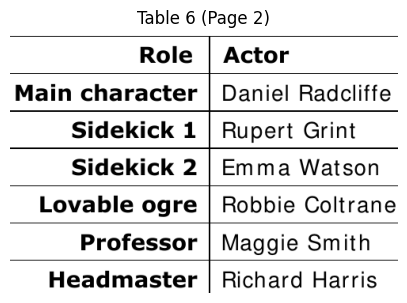

Saved cropped table to: /kaggle/working/croped/table_6_page2.png


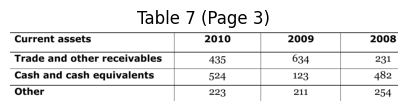

Saved cropped table to: /kaggle/working/croped/table_7_page3.png


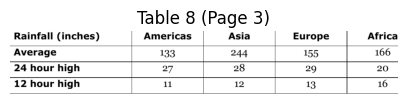

Saved cropped table to: /kaggle/working/croped/table_8_page3.png


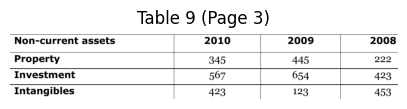

Saved cropped table to: /kaggle/working/croped/table_9_page3.png


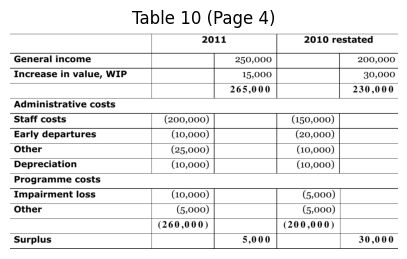

Saved cropped table to: /kaggle/working/croped/table_10_page4.png


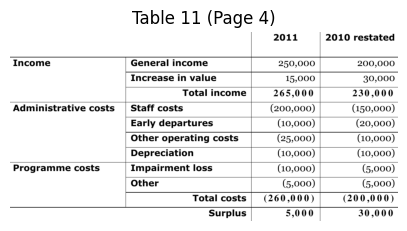

Saved cropped table to: /kaggle/working/croped/table_11_page4.png


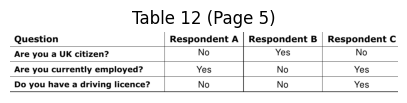

Saved cropped table to: /kaggle/working/croped/table_12_page5.png


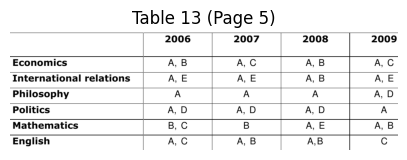

Saved cropped table to: /kaggle/working/croped/table_13_page5.png


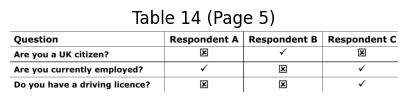

Saved cropped table to: /kaggle/working/croped/table_14_page5.png


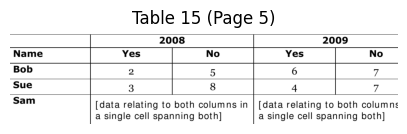

Saved cropped table to: /kaggle/working/croped/table_15_page5.png


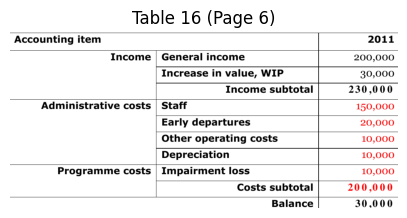

Saved cropped table to: /kaggle/working/croped/table_16_page6.png


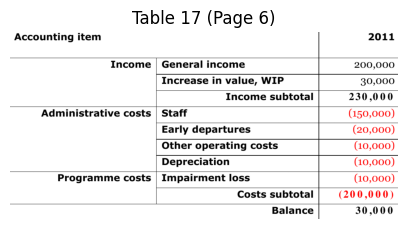

Saved cropped table to: /kaggle/working/croped/table_17_page6.png


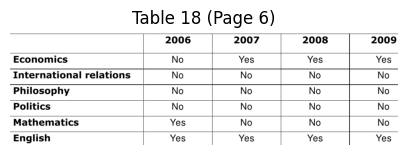

Saved cropped table to: /kaggle/working/croped/table_18_page6.png


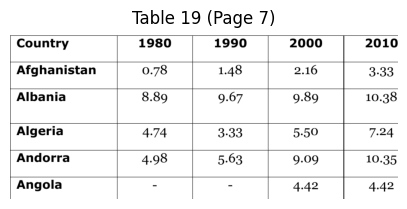

Saved cropped table to: /kaggle/working/croped/table_19_page7.png


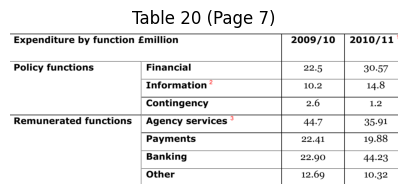

Saved cropped table to: /kaggle/working/croped/table_20_page7.png


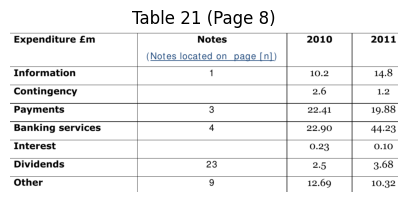

Saved cropped table to: /kaggle/working/croped/table_21_page8.png


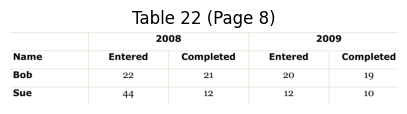

Saved cropped table to: /kaggle/working/croped/table_22_page8.png


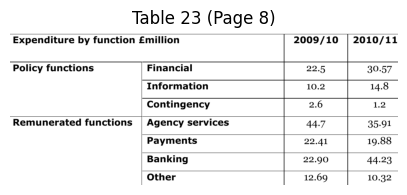

Saved cropped table to: /kaggle/working/croped/table_23_page8.png


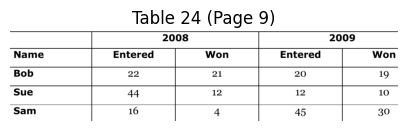

Saved cropped table to: /kaggle/working/croped/table_24_page9.png


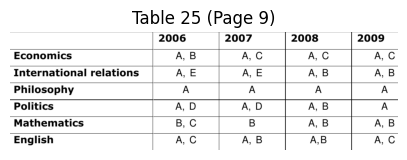

Saved cropped table to: /kaggle/working/croped/table_25_page9.png


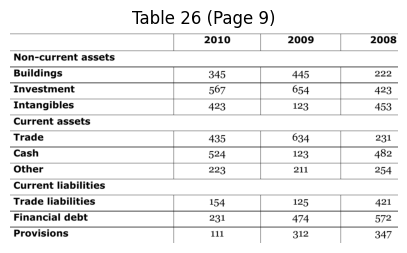

Saved cropped table to: /kaggle/working/croped/table_26_page9.png


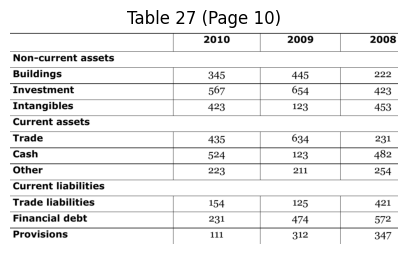

Saved cropped table to: /kaggle/working/croped/table_27_page10.png


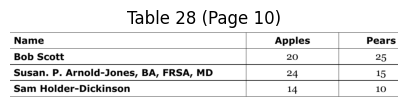

Saved cropped table to: /kaggle/working/croped/table_28_page10.png


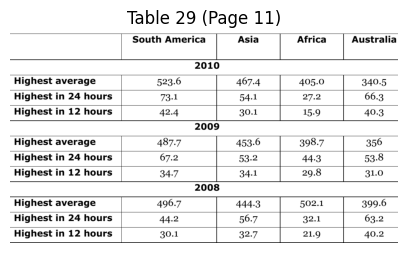

Saved cropped table to: /kaggle/working/croped/table_29_page11.png


In [9]:
import os

SAVE_DIR = "/kaggle/working/croped"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. Build a flat list of all tables across pages
all_tables = []
for page_idx, page_img in enumerate(images):
    results = detect_tables(page_img.convert("RGB"))
    for table_idx, box in enumerate(results["boxes"]):
        all_tables.append((page_idx, table_idx, box))

print(f"Total tables found: {len(all_tables)}")

# 2. Crop, display, and save each table with added padding
padding = 10  # Adjust this value for more or less space

for global_idx, (page_idx, table_idx, box) in enumerate(all_tables):
    img = images[page_idx]
    x1, y1, x2, y2 = map(int, box.tolist())

    # Add padding around the box
    x1 = max(0, x1 - padding)  # Ensure x1 doesn't go below 0
    y1 = max(0, y1 - padding)  # Ensure y1 doesn't go below 0
    x2 = min(img.width, x2 + padding)  # Ensure x2 doesn't go out of the image width
    y2 = min(img.height, y2 + padding)  # Ensure y2 doesn't go out of the image height
    
    cropped = img.crop((x1, y1, x2, y2))
    
    # Display the cropped table
    plt.figure(figsize=(5,5))
    plt.imshow(cropped)
    plt.axis("off")
    plt.title(f"Table {global_idx+1} (Page {page_idx+1})")
    plt.show()
    
    # Save the cropped image
    save_path = os.path.join(SAVE_DIR, f"table_{global_idx+1}_page{page_idx+1}.png")
    cropped.save(save_path)
    print(f"Saved cropped table to: {save_path}")